In [ ]:
# finding single and double-positive cells

In [2]:
library(Seurat)
library(dplyr)
library(ggplot2)
library(ggpointdensity)
library(cowplot)
library(viridis)
library(ggbeeswarm)

In [3]:
# dataset 2
sc1 = readRDS('hypomap_data.rds')
sc1
mtd1 = sc1@meta.data
mtd1[1:2,]

An object of class Seurat 
51676 features across 384925 samples within 1 assay 
Active assay: RNA (51676 features, 0 variable features)
 2 layers present: counts, data
 1 dimensional reduction calculated: umap

SRA_ID      Sample_ID           
AAACCCAAGGGTGAAA-1_SRR14252354 SRR14252354 Affinati10x_Sample_A
AAACCCACAGCACACC-1_SRR14252354 SRR14252354 Affinati10x_Sample_A
                               organism_ontology_term_id donor_id
AAACCCAAGGGTGAAA-1_SRR14252354 NCBITaxon:10090           pooled  
AAACCCACAGCACACC-1_SRR14252354 NCBITaxon:10090           pooled  
                               development_stage_ontology_term_id
AAACCCAAGGGTGAAA-1_SRR14252354 MmusDv:0000062                    
AAACCCACAGCACACC-1_SRR14252354 MmusDv:0000062                    
                               sex_ontology_term_id
AAACCCAAGGGTGAAA-1_SRR14252354 PATO:0000383        
AAACCCACAGCACACC-1_SRR14252354 PATO:0000383        
                               self_reported_ethnicity_ontology_term_id
AAACCCAAGGGTGAAA-1_SRR14252354 na                                      
AAACCCACAGCACACC-1_SRR14252354 na                                      
                               disease_ontology_term_id tissue_ontology_term_id
AAACCCAAGGGTGAAA-1_SRR14252354 PATO:0000461             UBERON:0001898         
AAACCCACAGCACACC-1_SRR14252354 PATO:0000461             UBERON:0001898         
                               cell_type_ontology_term_id ⋯ tissue_type
AAACCCAAGGGTGAAA-1_SRR14252354 CL:0000540                 ⋯ tissue     
AAACCCACAGCACACC-1_SRR14252354 CL:0000540                 ⋯ tissue     
                               cell_type assay     disease organism     sex   
AAACCCAAGGGTGAAA-1_SRR14252354 neuron    10x 3' v3 normal  Mus musculus female
AAACCCACAGCACACC-1_SRR14252354 neuron    10x 3' v3 normal  Mus musculus female
                               tissue       self_reported_ethnicity
AAACCCAAGGGTGAAA-1_SRR14252354 hypothalamus na                     
AAACCCACAGCACACC-1_SRR14252354 hypothalamus na                     
                               development_stage observation_joinid
AAACCCAAGGGTGAAA-1_SRR14252354 2-month-old stage ^J<ClZ-+1g        
AAACCCACAGCACACC-1_SRR14252354 2-month-old stage ;l|Z|wKd;$

In [4]:
table(mtd1$development_stage)


2-month-old stage  1-week-old stage  2-week-old stage  6-week-old stage 
           289482             30950             13864              6839 
 8-week-old stage  9-week-old stage  26-day-old stage  4-week-old stage 
             1887              1598              1516             25746 
   juvenile stage  23-day-old stage 
            10891              2152 

In [5]:
# cpm-normalize the raw counts
seu = CreateSeuratObject(counts = sc1@assays$RNA@counts, meta.data = sc1@meta.data)
seu <- NormalizeData(seu, normalization.method = "RC", scale.factor = 1e6)
exp1 = LayerData(seu, assay = 'RNA', layer = 'data') # cpm

Normalizing layer: counts



In [6]:
genes = sc1@assays$RNA@meta.features$feature_name
ids = which(!is.na(genes))
exp2 = exp1[ids,]
rownames(exp2) = genes[ids]
exp2[1:2,1:2]

2 x 2 sparse Matrix of class "dgCMatrix"
              AAACCCAAGGGTGAAA-1_SRR14252354 AAACCCACAGCACACC-1_SRR14252354
4933401J01Rik                              .                              .
Gm26206                                    .                              .

In [7]:
sum(exp2['Neurog2',]>0)
sum(exp2['Ascl1',]>0)
sum(exp2['Neurog1',]>0)

[1] 496

[1] 9606

[1] 22

In [8]:
# get new cell types for A1N2 and N1N2 cases
get_celltype_new <- function(exp0, g1, g2){
    gene1_exp = exp0[g1,]
    gene2_exp = exp0[g2,]
    
    vec1 = rank(gene1_exp)
    vec2 = rank(gene2_exp)
    
    vec1 <- vec1/max(vec1, na.rm = T)
    vec2 <- vec2/max(vec2, na.rm = T)

    id1 = which(vec1>0.7 & vec2>0.7) # dbl-positive
    id2 = which(vec1>0.7 & vec2<=0.7) # neurog2
    id3 = which(vec1<=0.7 & vec2>0.7) # ascl1

    ctypes = rep('none', dim(exp0)[2])
    ctypes[id1] = 'double_positive'
    ctypes[id2] = paste0(g1, '_positive')
    ctypes[id3] = paste0(g2, '_positive')

    return(ctypes)
}

In [9]:
# get cell type labels based on ranked exp bins
seu$celltype_A1N2 = get_celltype_new(exp2, 'Neurog2', 'Ascl1')
seu$celltype_N1N2 = get_celltype_new(exp2, 'Neurog2', 'Neurog1')

In [10]:
# save file
saveids = which(exp2['Neurog2',]>0 | exp2['Ascl1',]>0 | exp2['Neurog1',]>0)
length(saveids)

sce = CreateSeuratObject(counts = LayerData(seu, assay = 'RNA', layer = 'counts')[,saveids], 
                         data = exp2[,saveids], meta.data = seu@meta.data[saveids,])
sce

# save
saveRDS(sce, file = 'Steuernagel_A1N1N2.rds')

[1] 10103

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


An object of class Seurat 
103350 features across 10103 samples within 1 assay 
Active assay: RNA (103350 features, 0 variable features)
 2 layers present: counts, data

In [7]:
gene1_exp = exp2['Neurog2',]
gene2_exp = exp2['Ascl1',]

vec1 = rank(gene1_exp)
vec2 = rank(gene2_exp)

vec1 <- vec1/max(vec1, na.rm = T)
vec2 <- vec2/max(vec2, na.rm = T)

In [18]:
cor(vec1, vec2, method = 'spearman')

[1] 0.003378909

In [19]:
dat = data.frame(m1_exp = log2(1+gene1_exp), m2_exp = log2(1+gene2_exp),
                 m1_rank = vec1, m2_rank = vec2)
dat[1:2,]

m1_exp m2_exp m1_rank  m2_rank  
AAACCCAAGGGTGAAA-1_SRR14252354 0      0      0.499357 0.4875235
AAACCCACAGCACACC-1_SRR14252354 0      0      0.499357 0.4875235

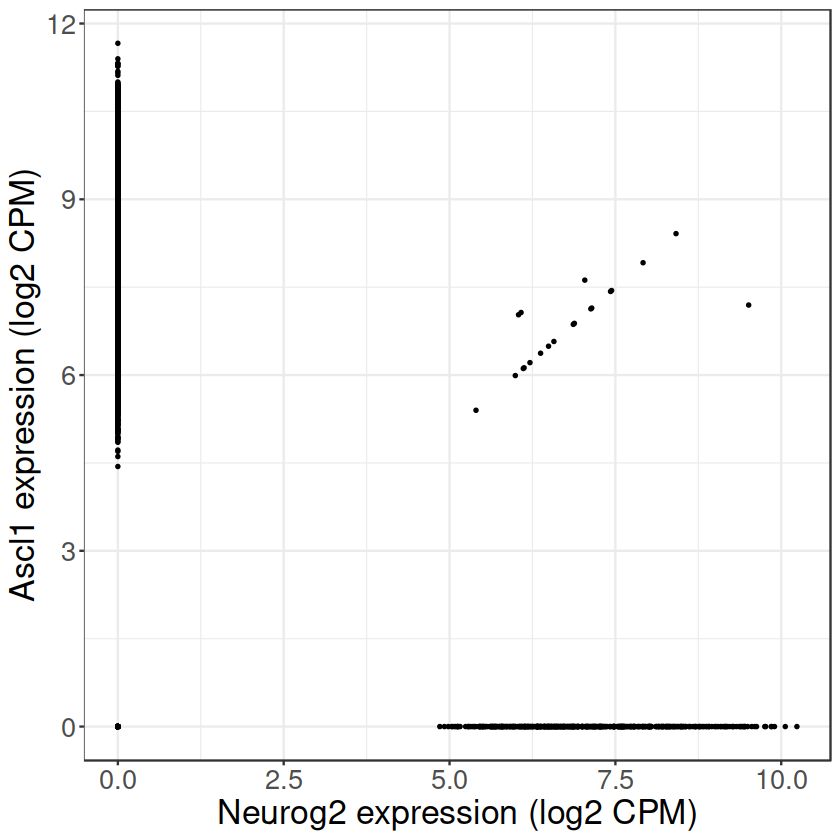

In [20]:
# png('aa-gene-exp-coexp.png', width = 5, height = 5, res = 300, units = 'in')
ggplot(dat, aes(x = m1_exp, y = m2_exp)) +
geom_point(size = 0.5) + theme_bw() + theme(text = element_text(size = 20)) +
xlab('Neurog2 expression (log2 CPM)') + ylab('Ascl1 expression (log2 CPM)')
# dev.off()

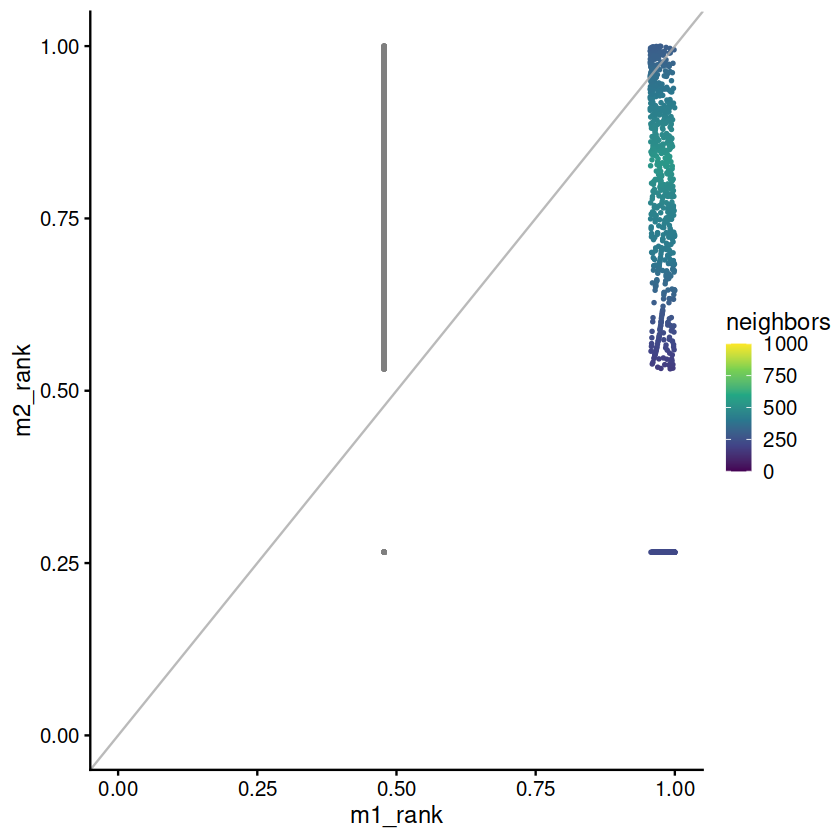

In [93]:
# png(paste0('aa-', g1, '-density-coexp.png'), width = 10, height = 5, res = 300, units = 'in')
# pdf(paste0('aa-hc-', g3, '-density-coexp.pdf'), width = 5, height = 5)

ggplot(dat, aes(x = m1_rank, y = m2_rank)) +
geom_pointdensity(size = 0.5) + scale_color_viridis_c(limits = c(0,1000)) + 
geom_abline(intercept = 0, slope = 1,col = 'darkgray', lwd = 0.5, alpha = 0.8)+
theme_cowplot() + labs(col = 'neighbors') + xlim(0,1) + ylim(0,1)

# dev.off()

In [8]:
id1 = which(vec1>0.7 & vec2>0.7) # dbl-positive
id2 = which(vec1>0.7 & vec2<0.7) # neurog2
id3 = which(vec1<0.7 & vec2>0.7) # ascl1

length(id1)
length(id2)
length(id3)

[1] 20

[1] 476

[1] 9586

In [22]:
# cluster 8,10,16,22 for dbl-pos; cluster 32 for neurog2+
table(as.character(mtd1$cell_type[id1]))


              neuron pituitary gland cell 
                  19                    1 

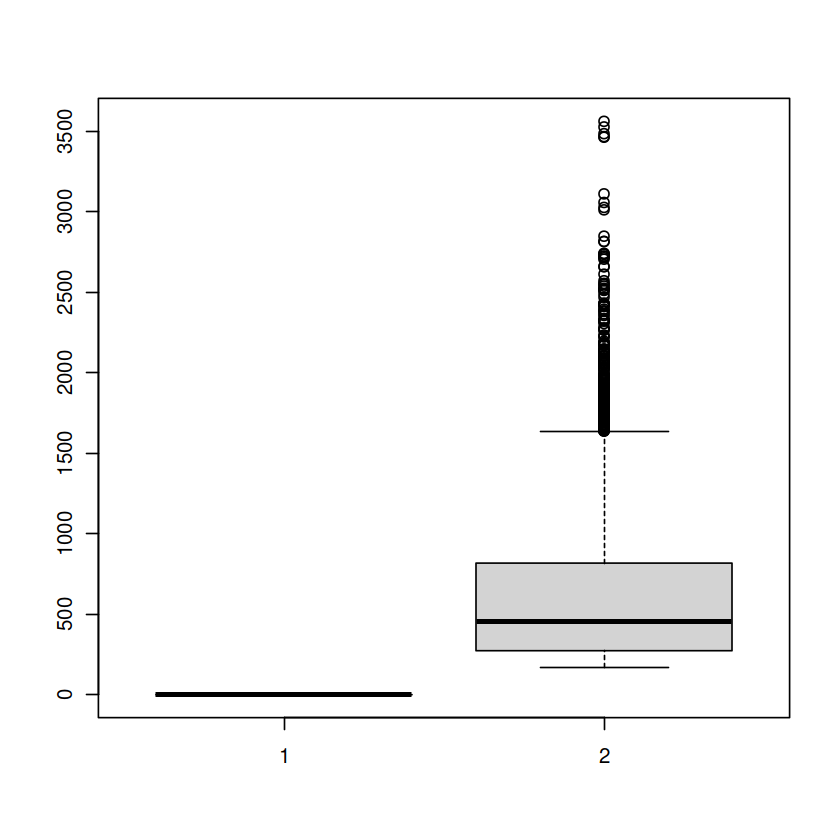

In [96]:
boxplot(exp1['Neurog2', id3], exp1['Ascl1', id3])

In [23]:
# Alex's target genes
alex = c('Bcl11a', 'Bcl11b', 'Nhlh1', 'Nhlh2', 'Sox2', 'Sox9', 'Gfap',
        'Pax6', 'Prom1', 'Foxj1', 'Rbfox3', 'Nes', 'Hopx', 'Dcx',
        'Bdnf', 'Pdgfra', 'S100b')
length(alex)

[1] 17

[1] "Cacng5"

[1] 16880

[1] 3

[1] 48

[1] 389

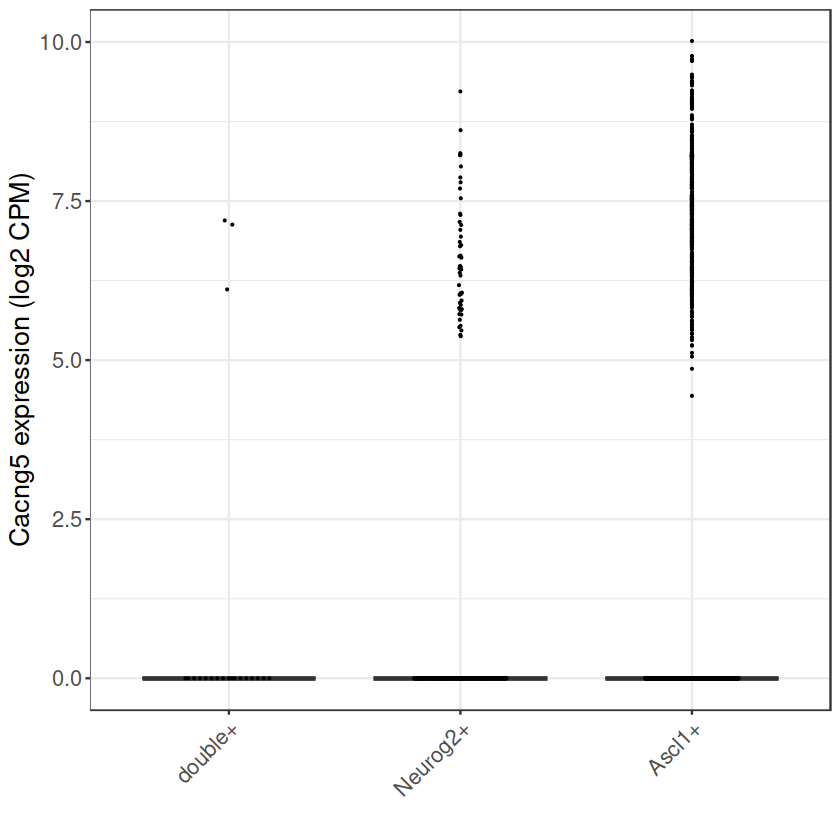

In [24]:
# other coexpressing genes
currgene = 'Cacng5'
currgene
sum(exp2[currgene,]>0)

# no. of cells with >0 exp in each case
sum(exp2[currgene, id1]>0)
sum(exp2[currgene, id2]>0)
sum(exp2[currgene, id3]>0)

exp_vec = exp2[currgene,]
vec3 = rank(exp_vec)
vec3 <- vec3/max(vec3, na.rm = T)
plotdf = data.frame(gene = currgene, 
                    ctype = c(rep('double+', length(id1)), rep('Neurog2+', length(id2)), rep('Ascl1+', length(id3))),
                    exp = c(log2(1+exp_vec[id1]), log2(1+exp_vec[id2]), log2(1+exp_vec[id3])),
                    rank_exp = c(vec3[id1], vec3[id2], vec3[id3]))
plotdf$ctype = factor(plotdf$ctype, levels = c('double+', 'Neurog2+', 'Ascl1+'))

# png(paste0('aa-', currgene, '-exp.png'), width = 3.5, height = 5, res = 300, units = 'in')
ggplot(plotdf, aes(x = ctype, y = exp, fill = ctype)) + 
geom_boxplot(outlier.shape = NA) + geom_quasirandom(size = 0.1, width = 0.2) + theme_bw() +
theme(text = element_text(size = 16), axis.text.x = element_text(angle = 45, hjust = 1), legend.position = 'none') +
xlab('') + ylab(paste0(currgene, ' expression (log2 CPM)')) + scale_fill_manual(values = c('#ff6b6b', '#48bf91', '#ffb403'))
# dev.off()

In [13]:
# which genes show the pattern we want? (apart from Alex's targets)
# expr in double-positive > single-positive cells
options(warn = -1)
allgenes = setdiff(rownames(exp2), c('Neurog2', 'Ascl1'))
length(allgenes)

# get row ranks
r1 = matrixStats::rowRanks(as.matrix(exp2[allgenes,c(id1,id2,id3)]))
r1 <- r1/dim(exp2)[2]

pb = txtProgressBar(min = 0, max = length(allgenes), initial = 0)
gset = c()

for(ii in 1:length(allgenes)){
    vec3 = r1[ii,]

    m1 = mean(vec3[1:length(id1)])
    m2 = mean(vec3[(length(id1)+1):(length(id1)+length(id2))])
    m3 = mean(vec3[(length(id1)+length(id2)+1):(length(id1)+length(id2)+length(id3))])
    
    if(m1>m2 & m1>m3){
        gset = c(gset, allgenes[ii])
    }
    setTxtProgressBar(pb, ii)
}

length(gset)

[1] 51674

[1] 6997

In [15]:
# wow, 10% follow our trend
pb = txtProgressBar(min = 0, max = length(gset), initial = 0)

dfnew = data.frame(gene = gset, dbl_exp = 0, gene1_exp = 0, 
                   gene2_exp = 0, retain = 0)

r2 = log2(1+exp2[gset,])

for(ii in 1:length(gset)){
    vec3 = r2[ii,]

    m1 = mean(vec3[id1])
    m2 = mean(vec3[id2])
    m3 = mean(vec3[id3])    

    dfnew$dbl_exp[ii] = m1
    dfnew$gene1_exp[ii] = m2
    dfnew$gene2_exp[ii] = m3
    
    if(m1>1.5*m2 & m1>1.5*m3 & m1>2){
        dfnew$retain[ii] = 1
    }
    setTxtProgressBar(pb, ii)
}
dfnew <- dfnew %>% arrange(-retain, -dbl_exp)

sum(dfnew$retain)
dfnew[1:2,]

[1] 900

gene   dbl_exp  gene1_exp gene2_exp retain
1 Trh    8.532218 2.799877  0.6366095 1     
2 Nap1l1 7.747630 5.022224  4.1865023 1

In [16]:
dfnew$gene[dfnew$retain==1]

[1] "Trh"                              "Nap1l1"                          
  [3] "Zc3h15"                           "Macroh2a1"                       
  [5] "Cnot4"                            "Ctnnd2"                          
  [7] "Pnck"                             "Magi2"                           
  [9] "Dlg2"                             "Rapgef6"                         
 [11] "Gng2"                             "Emc4"                            
 [13] "Grid2"                            "Ccnl2"                           
 [15] "Uba52"                            "Baiap3"                          
 [17] "Celf5"                            "Vps13a"                          
 [19] "Pde4d"                            "Ngb"                             
 [21] "Scmh1"                            "Calb1"                           
 [23] "Tle4"                             "Jak1"                            
 [25] "Tln2"                             "Gabrg3"                          
 [27] "Zdbf2"                            "Fndc3a"                          
 [29] "Fnbp1l"                           "Chd8"                            
 [31] "Supt20"                           "Spock1"                          
 [33] "Denr"                             "Gramd1b"                         
 [35] "Trp53bp1"                         "Plcb1"                           
 [37] "Kcnh7"                            "Nav3"                            
 [39] "Ppfia2"                           "Zmym4"                           
 [41] "Kansl1"                           "Rnpc3"                           
 [43] "Arih1"                            "Appl1"                           
 [45] "Esf1"                             "Nvl"                             
 [47] "Nufip2"                           "Nop56"                           
 [49] "Marchf7"                          "Gm44644"                         
 [51] "B830012L14Rik"                    "Cbln2"                           
 [53] "Rock1"                            "Gm26871"                         
 [55] "Trpc5"                            "Cacna1d"                         
 [57] "Pigp"                             "Stard3nl"                        
 [59] "Gm26782"                          "Flrt3"                           
 [61] "Mrtfb"                            "Scfd1"                           
 [63] "Mtss1"                            "Cnot7"                           
 [65] "Scn9a"                            "Trappc3"                         
 [67] "Ube2w"                            "Sdc2"                            
 [69] "Wapl"                             "Plekha5"                         
 [71] "Grm7"                             "Tmem255a"                        
 [73] "Fam3c"                            "Sncg"                            
 [75] "Nav2"                             "Ccdc174"                         
 [77] "Setx"                             "Sh3kbp1"                         
 [79] "Dab1"                             "Asic2"                           
 [81] "Blmh"                             "Nxph4"                           
 [83] "Tmem38a"                          "Glt8d1"                          
 [85] "Shprh"                            "Stxbp5l"                         
 [87] "Shoc2"                            "Senp7"                           
 [89] "Hyi"                              "Kcnc2"                           
 [91] "AW551984"                         "Dop1a"                           
 [93] "Scaf8"                            "Dhx15"                           
 [95] "Cplx2"                            "Sanbr"                           
 [97] "Ufd1"                             "Rbm33"                           
 [99] "Stag1"                            "3830406C13Rik"                   
[101] "Mesd"                             "Dapk1"                           
[103] "Agrn"                             "Atad2b"                          
[105] "Actr1a"                           "Hook1"  

In [17]:
# df for saving
write.table(dfnew, file = 'steuernagel_neurog2_ascl1_geneset.csv', sep = ',',
           row.names = F, col.names = T, quote = F)

In [42]:
# show avg exp and pct expressed
geneset = rev(c('Nes', 'Thrsp', 'Gpc5', 'Efhd2', 'Gpc4', 'Gli2', 'Adarb1'))
plotdf2 = c()

for(ii in 1:length(geneset)){
    currgene = geneset[ii]
    exp_vec = exp1[currgene,]
    
    temp = data.frame(gene = currgene, 
                        ctype = c('double+', 'Neurog2+', 'Ascl1+'),
                        log2_exp = c(mean(log2(1+exp_vec[id1])), mean(log2(1+exp_vec[id2])), mean(log2(1+exp_vec[id3]))),
                        pct_exp = c(sum(exp1[currgene, id1]>0)/length(id1), 
                                sum(exp1[currgene, id2]>0)/length(id2), sum(exp1[currgene, id3]>0)/length(id3)))
    plotdf2 = rbind(plotdf2, temp) 
}

plotdf2$ctype = factor(plotdf2$ctype, levels = c('double+', 'Neurog2+', 'Ascl1+'))
plotdf2$gene = factor(plotdf2$gene, levels = geneset)
plotdf2[1:3,]

gene   ctype    log2_exp  pct_exp  
1 Adarb1 double+  0.6800809 0.1255230
2 Adarb1 Neurog2+ 0.6340548 0.1023018
3 Adarb1 Ascl1+   0.7318099 0.1314126

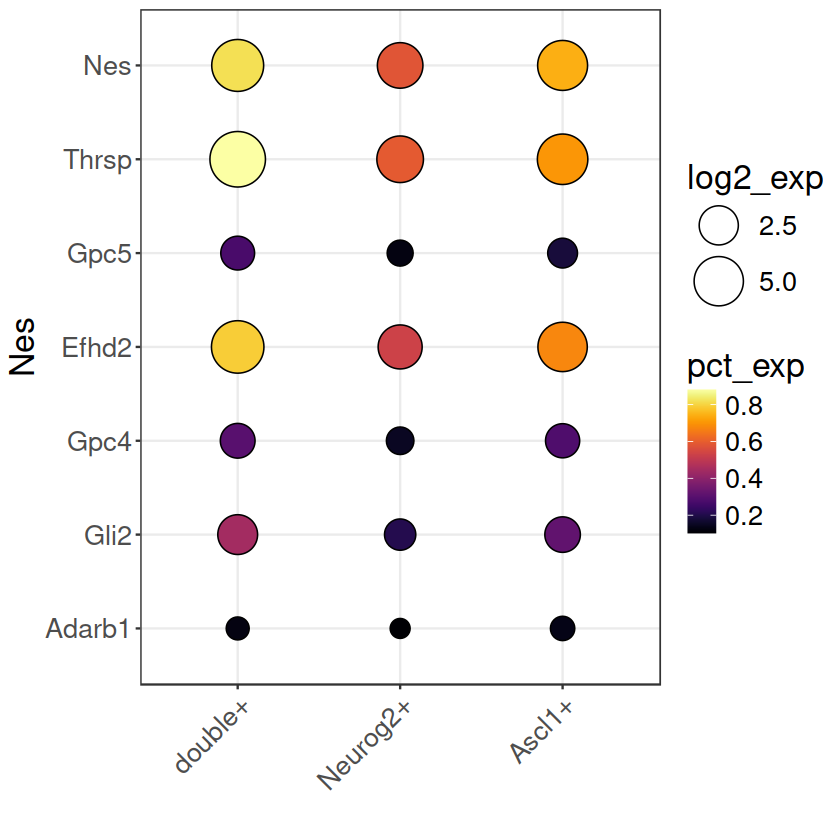

In [45]:
# png('aa-geneset-exp-pct.png', width = 5, height = 6, res = 300, units = 'in')
ggplot(plotdf2, aes(x = ctype, y = gene, label = round(pct_exp*100)/100)) +  
geom_point(shape = 21, color = 'black', aes(fill = pct_exp, size = log2_exp)) + theme_bw() + 
# geom_text(size = 6, hjust = -0.25, vjust = -2) + 
theme(text = element_text(size = 20), axis.text.x = element_text(angle = 45, hjust = 1)) +
xlab('') + ylab(currgene) + scale_fill_viridis(option = 'B') +
scale_size_continuous(breaks = c(0, 2.5, 5, 7.5, 10, 12.5, 15), range = c(5, 15)) 
# dev.off()